In [8]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.vis_data import *
from src.visualization.vis_model import *
from src.models.train_model import *
from src.models.predict_model import * 
from src.models.predict_model import _reduct_effect_q
plt.rcParams.update({'font.size': 16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [35]:
rawplot_folder = '../reports/raw_plot/'

# Model Performance

In [5]:
dataset, model, fire_cols, zone_list, feat_imp, roll_win = load_model(city='Chiang Mai', pollutant='PM2.5', split_list=[0.7, 0.3])

rolling_win 1
data no fire has shape (77747, 14)
raw model performance {'test_r2_score': 0.7121741191572741, 'test_mean_squared_error': 225.0349762955199, 'test_mean_absolute_error': 9.128607580733833}
daily avg training error {'avg_trn_r2_score': 0.9494013040693593, 'avg_trn_mean_squared_error': 33.06276548158929, 'avg_trn_mean_absolute_error': 3.565871600652085}
daily avg test error {'avg_test_r2_score': 0.7853115268602168, 'avg_test_mean_squared_error': 144.04759287073333, 'avg_test_mean_absolute_error': 7.615834990020282}


In [8]:
feat_imp.to_csv(rawplot_folder+'feature_of_importance.csv',index=False)

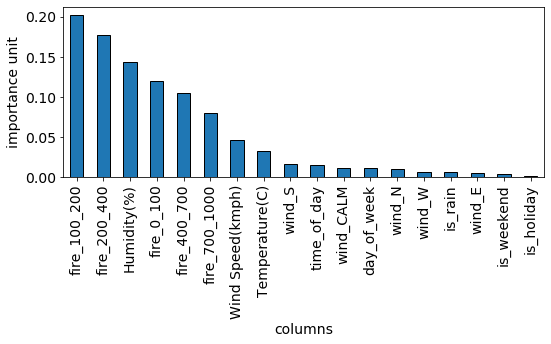

In [20]:
show_fea_imp(feat_imp,x_log=False, filename=None,title='')

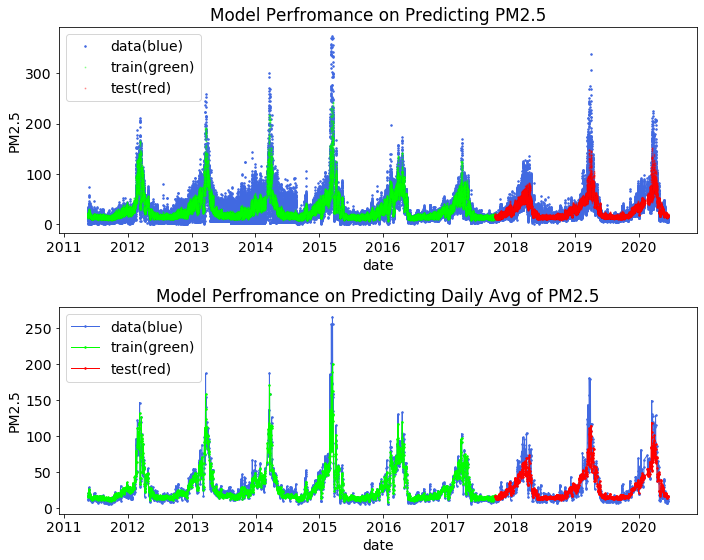

In [233]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=data, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

In [346]:
# calculate the average error
trn_error = cal_error(data, model, data_index=data.split_list[0])

# resample
ytrn_pred_df_avg = trn_error.resample('d').mean().dropna()
cal_scores(ytrn_pred_df_avg['actual'].values, ytrn_pred_df_avg['pred'].values, header_str='avg_trn_')

{'avg_trn_r2_score': 0.9450132986667232,
 'avg_trn_mean_squared_error': 35.925725806931965,
 'avg_trn_mean_absolute_error': 3.7745352329778226}

In [347]:
# calculate the average error
ytest_pred_df = cal_error(data, model, data_index=data.split_list[1])

# resample
ytest_pred_df_avg = ytest_pred_df.resample('d').mean().dropna()
cal_scores(ytest_pred_df_avg['actual'].values, ytest_pred_df_avg['pred'].values, header_str='avg_test_')

{'avg_test_r2_score': 0.7828068417310021,
 'avg_test_mean_squared_error': 145.74247345984156,
 'avg_test_mean_absolute_error': 7.717591182233365}

## Average Error

Text(0.5, 1.0, 'error (by pollution season)')

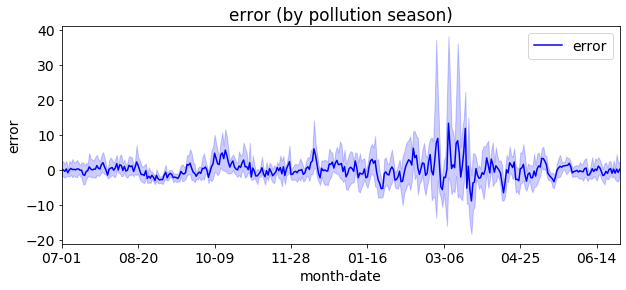

In [348]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(trn_error, 'error', ax, plot_error=True, roll=False, agg='mean')
ax.set_title('error (by pollution season)')

Text(0.5, 1.0, 'rmse (by pollution season)')

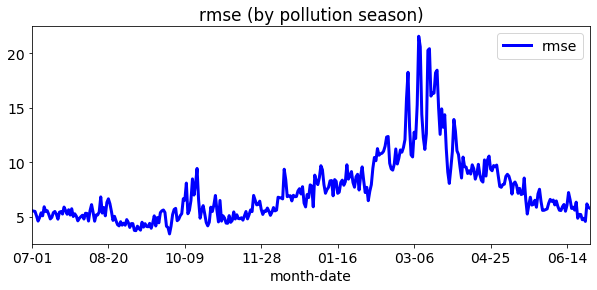

In [349]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(trn_error, 'rmse', ax, plot_error=False, roll=True, agg='mean')
ax.set_title('rmse (by pollution season)')

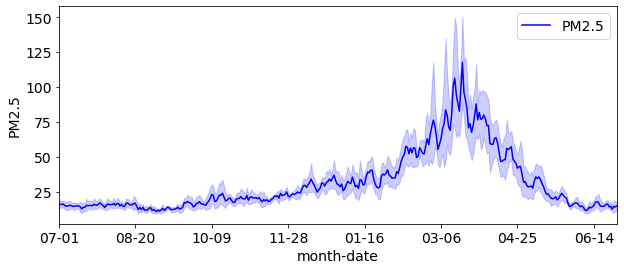

In [194]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(data.data, 'PM2.5', ax, plot_error=True, roll=False, agg='mean')

# Inference

In [2]:
inferer = Inferer(city_name='Chiang Mai', pollutant='PM2.5')
dataset = inferer.dataset

data no fire has shape (77747, 14)
raw model performance {'test_r2_score': 0.6971263012454727, 'test_mean_squared_error': 236.87171030783028, 'test_mean_absolute_error': 9.356311166795104}
daily avg training error {'avg_trn_r2_score': 0.9750555507848502, 'avg_trn_mean_squared_error': 16.30387143688307, 'avg_trn_mean_absolute_error': 2.4689413599174954}
daily avg test error {'avg_test_r2_score': 0.7774020193313866, 'avg_test_mean_squared_error': 149.34608153552455, 'avg_test_mean_absolute_error': 7.808431861215025}
max error 15.062821731493033


In [3]:
%%time
inferer.get_data_sample_(n_samples=100, step=1,day_err=10,hour_err=2)

obtaining inference samples. This will take about 15 mins


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23693/23693 [09:04<00:00, 43.53it/s]


datasample has shape (2115613, 142)
Wall time: 9min 53s


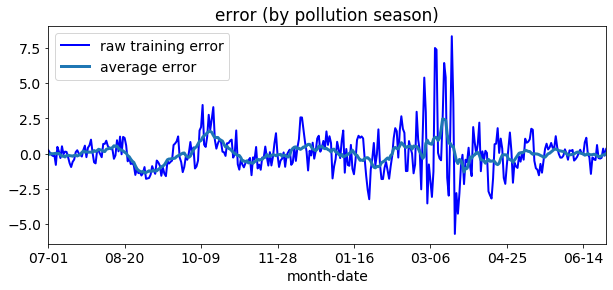

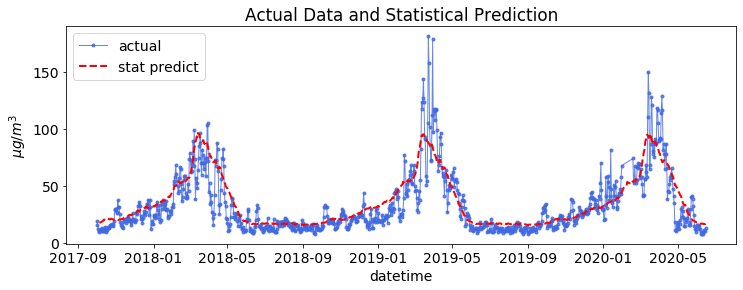

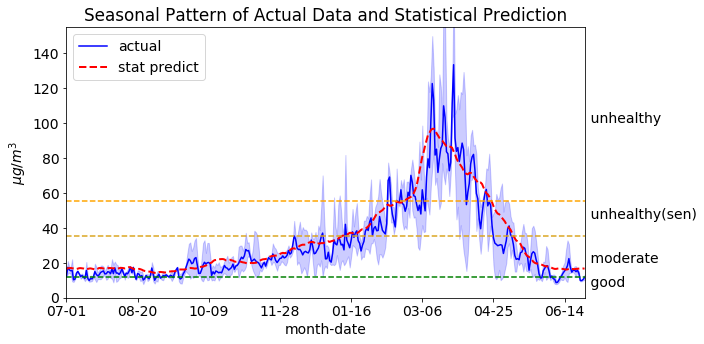

In [60]:
inferer.compare_inf_act()

In [ ]:
sea_pred = _reduct_effect_q(inferer.model, inferer.data_samples, ['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700'], inferer.sea_error, q=0.75, per_cut=0.5)


In [32]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


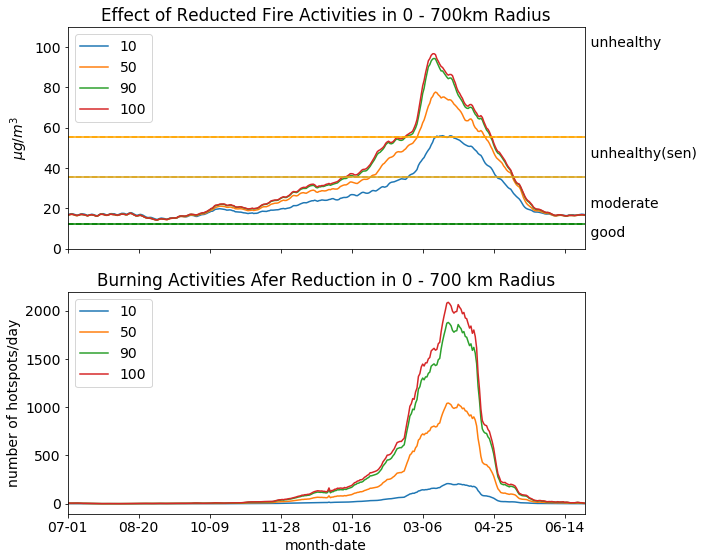

In [58]:
data = inferer.dataset
fire_hour = data.fire[data.fire['distance'] <= 700].copy()
fire_hour = fire_hour[['count']].resample('d').sum()
col = ['number of hotspots']
fire_hour.columns = col
fire_hour = fire_hour.rolling(5, min_periods=0).agg('mean').copy().dropna()
sep_fire, winter_day_dict = season_avg(fire_hour, cols= col, roll=False, agg='mean', offset=182) 
sep_fire = sep_fire.groupby('winter_day').mean()[col]
red_list = [0.9, 0.5, 0.1, 0]
red_fire = []
#colors = ['#1f77b4', '#2ca02c', '#9467bd', '#7f7f7f']
for per_cut in red_list:
    temp = sep_fire*(1-per_cut)
    temp.columns = [int(round(1-per_cut,2)*100)]
    red_fire.append(temp)
    
red_fire = pd.concat(red_fire, axis=1)

_, a = plt.subplots(2,1, figsize=(10,8),sharex=True)

ax = a[1]
red_fire.plot(ax=ax)
ax.legend(red_fire.columns, loc='upper left')
ax.set_title('Burning Activities Afer Reduction in 0 - 700 km Radius')
ax.set_xlim([red_fire.index.min(), red_fire.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']    
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')

fea_effect = inferer.features_effect_season(features=['fire_0_100', 'fire_100_200', 'fire_200_400', 'fire_400_700'], q=0.75, ax=a[0],red_list=[0.9, 0.5, 0.1, 0])
a[0].set_title('Effect of Reducted Fire Activities in 0 - 700km Radius')
plt.tight_layout()

plt.savefig(inferer.report_folder + 'effect_fire_0_700km_sea.png')


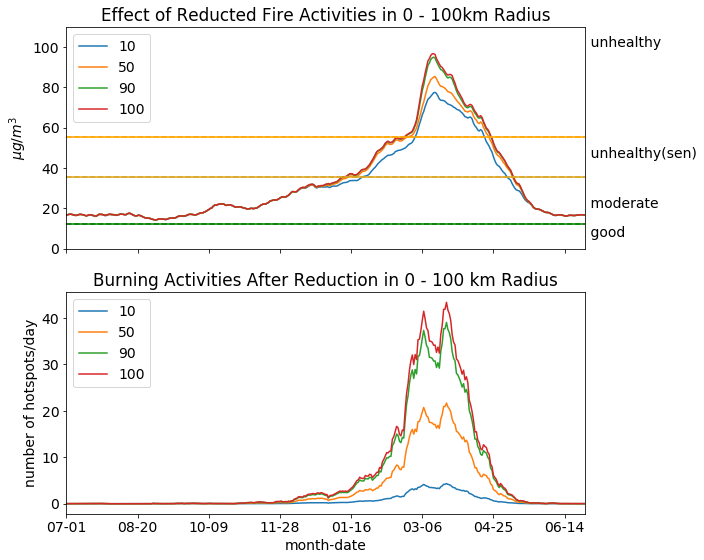

In [59]:
data = inferer.dataset
fire_hour = data.fire[data.fire['distance'] <= 100].copy()
fire_hour = fire_hour[['count']].resample('d').sum()
col = ['number of hotspots']
fire_hour.columns = col
fire_hour = fire_hour.rolling(5, min_periods=0).agg('mean').copy().dropna()
sep_fire, winter_day_dict = season_avg(fire_hour, cols= col, roll=False, agg='mean', offset=182) 
sep_fire = sep_fire.groupby('winter_day').mean()[col]
red_list = [0.9, 0.5, 0.1, 0]
red_fire = []
#colors = ['#1f77b4', '#2ca02c', '#9467bd', '#7f7f7f']
for per_cut in red_list:
    temp = sep_fire*(1-per_cut)
    temp.columns = [int(round(1-per_cut,2)*100)]
    red_fire.append(temp)
    
plot_data_list = []    
red_fire = pd.concat(red_fire, axis=1)
plot_data_list.append(red_fire)

_, a = plt.subplots(2,1, figsize=(10,8),sharex=True)

ax = a[1]
red_fire.plot(ax=ax)
ax.legend(red_fire.columns, loc='upper left')
ax.set_title('Burning Activities After Reduction in 0 - 100 km Radius')
ax.set_xlim([red_fire.index.min(), red_fire.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']    
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')

fea_effect = inferer.features_effect_season(features=['fire_0_100'], q=0.75, ax=a[0],red_list=[0.9, 0.5, 0.1, 0])
plot_data_list.append(fea_effect)
a[0].set_title('Effect of Reducted Fire Activities in 0 - 100km Radius')
plt.tight_layout()
plt.savefig(inferer.report_folder + 'effect_fire_0_100km_sea.png')

# explore raw plot
h_filename = rawplot_folder +'effect_fire_0_100km_sea'
for i, df in enumerate(plot_data_list):
    df.to_csv(h_filename + f'{i}.csv', index=False)


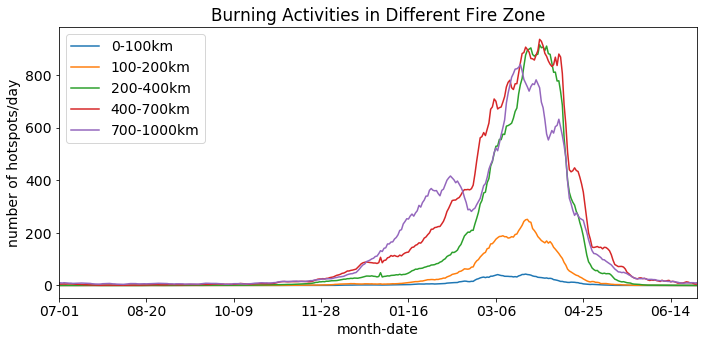

In [38]:
# Plot number of hotspot/day in different fire zone
inner = 0
num_fire_df = []
for distance in inferer.zone_list[1:]: 
    fire_hour = dataset.fire[(dataset.fire['distance']>inner )&(dataset.fire['distance'] <= distance)].copy()
    fire_hour = fire_hour[['count']].resample('d').sum()
    col = [f'{inner}-{distance}km']
    inner = distance
    fire_hour.columns = col 
    fire_hour = fire_hour.rolling(5, min_periods=0).agg('mean').copy().dropna()
    sea_fire, winter_day_dict = season_avg(fire_hour, cols= col, roll=False, agg='mean', offset=182) 
    sea_fire = sea_fire.groupby('winter_day').mean()[col]
    num_fire_df.append(sea_fire)
    
num_fire_df = pd.concat(num_fire_df, axis=1)

_, ax = plt.subplots(1,1, figsize=(10,5),sharex=True)
ax.plot(num_fire_df)
ax.legend(num_fire_df.columns, loc='upper left')
ax.set_title('Burning Activities in Different Fire Zone')
ax.set_xlim([num_fire_df.index.min(), num_fire_df.index.max()])
new_ticks = ['07-01', '08-20', '10-09', '11-28', '01-16', '03-06', '04-25', '06-14', '']  
ax.set_xticklabels(new_ticks)
ax.set_xlabel('month-date')
ax.set_ylabel('number of hotspots/day')
plt.tight_layout()

plt.savefig(inferer.report_folder + 'num_fires_sea.png')


In [39]:
%%time

features = inferer.feat_imp['index'][inferer.feat_imp['index'].str.contains('fire')][:5]
zone_list = inferer.zone_list
feature_list = []
columns_list = []
for i in range(1,6):
    fea = features[:i]
    feature_list.append(fea)
    columns_list.append(f'fire {zone_list[0]}-{zone_list[i]}km')
    
fea_effect_3m = inferer.features_effect_sum(feature_list, q=0.75, red_list=[0, 0.1, 0.25, 0.5, 0.75, 0.9], time_range=[185,305],agg='mean', raw_filename= rawplot_folder +'effect_of_fire_reduction_3m' )
fea_effect_3m.columns = columns_list

fea_effect_3m.to_csv(rawplot_folder +'effect_of_fire_reduction_3m.csv',index=False)


Wall time: 36min 36s


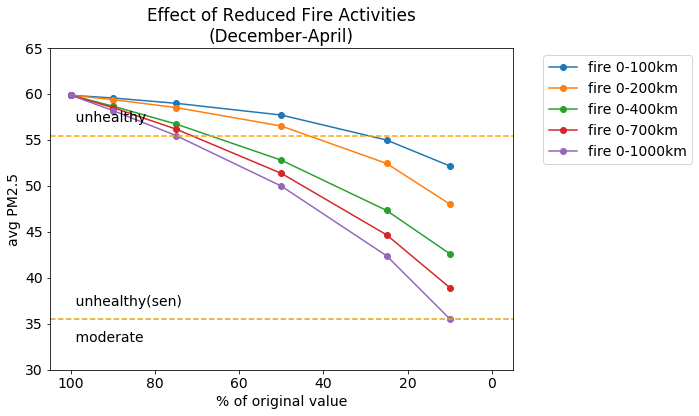

In [56]:
plt.figure(figsize=(10,6))
plt.title("Effect of Reduced Fire Activities\n(December-April)")
columns_list = [fill(l,25) for l in fea_effect_3m.columns]
plt.plot(fea_effect_3m, marker='o')
plt.legend(columns_list, bbox_to_anchor=(1.05, 1))
plt.xlim(105, -5) 
plt.xlabel('% of original value')
plt.ylabel('avg PM2.5')
plt.ylim([30, 65])

for l, c in inferer.color_zip:
    plt.axhline(l, color=c, linestyle='dashed')
    
plt.text(100, 33, ' moderate',  horizontalalignment='left')
plt.text(100, 37, ' unhealthy(sen)',  horizontalalignment='left')
plt.text(100, 57, ' unhealthy',  horizontalalignment='left')

plt.tight_layout()
plt.savefig(inferer.report_folder + 'effect_of_fire_reduction_3m.png')


In [41]:
%%time

features = inferer.feat_imp['index'][inferer.feat_imp['index'].str.contains('fire')][:5]
zone_list = inferer.zone_list
feature_list = []
columns_list = []
for i in range(1,6):
    fea = features[:i]
    feature_list.append(fea)
    columns_list.append(f'fire {zone_list[0]}-{zone_list[i]}km')
    
fea_effect_mar = inferer.features_effect_sum(feature_list, q=0.75, red_list=[0, 0.1, 0.25, 0.5, 0.75, 0.9], time_range=[245,275],agg='mean', raw_filename= rawplot_folder +'effect_of_fire_reduction_mar' )
fea_effect_mar.to_csv(rawplot_folder +'effect_of_fire_reduction_mar.csv',index=False)


Wall time: 29min 5s


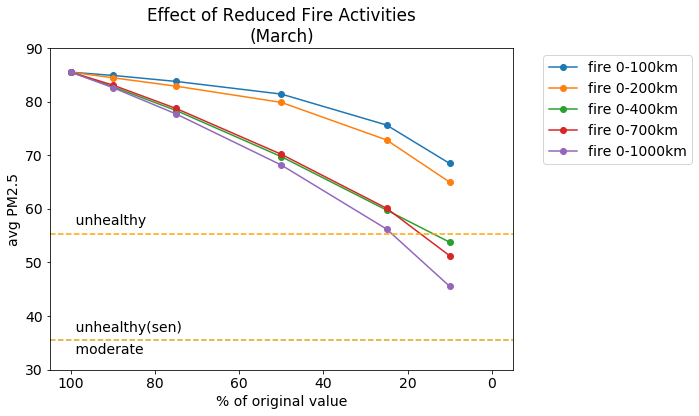

In [55]:
plt.figure(figsize=(10,6))
plt.title("Effect of Reduced Fire Activities\n(March)")
columns_list = [fill(l,20) for l in fea_effect_3m.columns]
plt.plot(fea_effect_mar, marker='o')
plt.legend(columns_list, bbox_to_anchor=(1.05, 1))
plt.xlim(105, -5) 
plt.xlabel('% of original value')
plt.ylabel('avg PM2.5')
plt.ylim([30, 90])

for l, c in inferer.color_zip: 
    plt.axhline(l, color=c, linestyle='dashed')
    
plt.text(100, 33, ' moderate',  horizontalalignment='left')
plt.text(100, 37, ' unhealthy(sen)',  horizontalalignment='left')
plt.text(100, 57, ' unhealthy',  horizontalalignment='left')
plt.tight_layout()
    
plt.savefig(inferer.report_folder + 'effect_of_fire_reduction_mar.png')

# Animation

In [65]:
def show_city(dataset, stepx=800E3, stepy=800E3, color='black'):
    """Load city location and plot the city center on the map
    
    Args:
        dataset object
        stepx: height of the map in meter 
        stepy: width of the map in meter
        color: color of the circle to mark the city center 
        
    Returns 
        p: bokeh figure object 
        city_x: Longitude in mercator
        city_y: Latitude in mercator 
    """ 
    city_x = merc_x(dataset.city_info['Longitude'])
    city_y = merc_y(dataset.city_info['Latitude'])
    
    x_range = [city_x - stepx, city_x + stepx]
    y_range = [city_y-stepy*0.5, city_y+stepy*0.0001]
    
    p = figure(plot_width=500, plot_height=500, toolbar_location=None, title='burning activities', 
            x_range=x_range, y_range=y_range, x_axis_type="mercator", y_axis_type="mercator")
    
    # add map
    p.add_tile(get_provider(Vendors.STAMEN_TERRAIN_RETINA))
    
    # add city center 
    #p.circle(city_x, city_y, color=color, line_color='black',size=5, legend_label=dataset.city_name)
   
    return p, city_x, city_y 

In [66]:
def plot_base_effect(df,  title='avg Dec-Apr', plot_width=250, plot_height=250, y_range=[32, 65], color='grey', alpha=1, line_values=[36,56]):
    """Plot base plot of the average pollution level from filename.
    
    Load the file specified by the filename and plot data in grey color 
    
    Args:
        df: dataframe to plot
        title
        plot_width: width of the plot
        plot_height: height of the plot
        color: color of the plot
        y_range: 
        alpha: transparency level 
        line_values: value for the horizontal color lines to make the pollution limit 
        
    Return bokeh figure object 
    
    """
    p = figure(plot_width=plot_width, plot_height=plot_height,  toolbar_location=None, title=title, y_range=y_range,x_range=[105, 0])
    p.xaxis.axis_label = '% of original value'
    p.yaxis.axis_label = 'PM2.5 level(μg/m²)'
    
    # add horizontal lines
    line = Span(location=line_values[0], dimension='width', line_color='orange', line_dash='dashed')
    p.add_layout(line)
    text = Label(x=100, y=32, text='moderate')
    p.add_layout(text)

    line = Span(location=line_values[1], dimension='width', line_color='red', line_dash='dashed')
    p.add_layout(line)
    text = Label(x=100, y=45, text='unhealthy(sen)')
    text = Label(x=100, y=52, text='unhealthy')
    p.add_layout(text)
    
    
    #df = pd.read_csv(filename)
    
    for col in df.columns:
        p.circle(df.index, df[col],color=color, alpha=alpha)
        p.line(df.index, df[col],color=color, alpha=alpha)
        
    #p.xaxis.ticker = FixedTicker(ticks=[100, 80, 60, 40, 20, 0, -20])
    
    return p
    

In [67]:
def plot_base_season(head_filename, plot_width=250, plot_height=250, color='grey', alpha=1, line_values=[36,56]):
    """Plot base seasonal pattern pollution level from different head_filename.
    
    Load the file specified by the head_filename+*.csv. Load all the data and plot data in grey color 
    
    Args:
        filename: plot data file 
        plot_width: width of the plot
        plot_height: height of the plot
        color: color of the plot
        y_range: 
        alpha: transparency level 
        line_values: value for the horizontal color lines to make the pollution limit 
        
    Return bokeh figure object 
    
    """ 
    p = figure(plot_width=plot_width, plot_height=plot_height, toolbar_location=None, title='seasonal pattern')    
    p.xaxis.axis_label = 'month'
    p.yaxis.axis_label = 'PM2.5 level(μg/m²)'
    
    # add horizontal lines
    line = Span(location=line_values[0], dimension='width', line_color='orange', line_dash='dashed')
    p.add_layout(line)
    text = Label(x=0, y=25, text='moderate')
    p.add_layout(text)

    line = Span(location=line_values[1], dimension='width', line_color='red', line_dash='dashed')
    p.add_layout(line)
    text = Label(x=0, y=37, text='unhealthy(sen)')
    p.add_layout(text)
    
    files = glob(head_filename+'*.csv')
    for file in files:
        df = pd.read_csv(file).set_index('winter_day')
        for col in df.columns:
            p.line(df.index, df[col], color=color, alpha=alpha)
    
    # define xticks label 
    
    p.xaxis.ticker = FixedTicker(ticks=[0, 62, 123, 185, 245, 306])
    xaxis_dict = {0:"Jul", 62:"Sept", 123:'Nov' , 185: "Jan", 245: "Mar", 306:"May" }
    p.xaxis.major_label_overrides = xaxis_dict

    
    return p

In [68]:
def plot_one_effet(radius, color, percent, avg_df, filename, p1, p2, p3):
    """Plot individual effect of each fire zone and percent reduction
    
    """
    label = f'0 - {radius}km'
    
    # plot average lines 
    col = f'fire 0-{radius}km'
    p1.line(avg_df.index, avg_df.loc[:, col],color=color,line_width=3)
    p1.circle(percent, avg_df.loc[percent, col],color=color,line_color='black', size=8)
    text = Label(x=5, y=61, text=label, text_font_size='12pt', text_align='right',  text_color=color_list[0])
    p1.add_layout(text)
    
    # plot seasonal line 
    text = Label(x=0, y=90, text=label, text_font_size='12pt', text_align='left', text_color=color_list[0])
    p2.add_layout(text)
    text = Label(x=0, y=80, text=f'{percent}% fire', text_font_size='12pt', text_align='left', text_color=color_list[0])
    p2.add_layout(text)

    df = pd.read_csv(filename).set_index('winter_day')
    p2.line(df.index, df[str(percent)], color=color, line_width=3)
    
    # addcircle to map plot
    xy = get_circle(city_x, city_y,r=radius*1E3)
    p3.line(xy[0,:],xy[1,:],alpha=1,line_width=2,line_color=color, legend_label=label)
    
    # add city center  
    text = Label(x=city_x, y=city_y, text=f'Chiang Mai', text_font_size='15pt', text_color='black')
    p3.add_layout(text)
    # add city center dot
    p3.circle(city_x, city_y, color='black', line_color='black',size=5)
    

In [69]:
# load inference dataset
inferer = Inferer(city_name='Chiang Mai', pollutant='PM2.5')
dataset = inferer.dataset

data no fire has shape (77747, 14)
raw model performance {'test_r2_score': 0.6971263012454727, 'test_mean_squared_error': 236.87171030783028, 'test_mean_absolute_error': 9.356311166795104}
daily avg training error {'avg_trn_r2_score': 0.9750555507848502, 'avg_trn_mean_squared_error': 16.30387143688307, 'avg_trn_mean_absolute_error': 2.4689413599174954}
daily avg test error {'avg_test_r2_score': 0.7774020193313866, 'avg_test_mean_squared_error': 149.34608153552455, 'avg_test_mean_absolute_error': 7.808431861215025}
max error 15.062821731493033


In [70]:
# calculate the number of hotspots between december and april 
inner = 0
num_fire_df = []

for distance in inferer.zone_list[1:]: 
    fire_hour  = dataset.fire[(dataset.fire['distance']>inner )&(dataset.fire['distance'] <= distance)] 
    fire_hour = fire_hour[['count']].resample('d').count().copy()
    col = [f'{inner}-{distance}km']
    inner = distance
    fire_hour.columns = col 
    fire_hour = fire_hour.rolling(5, min_periods=0).agg('mean').copy().dropna()
    sea_fire, winter_day_dict = season_avg(fire_hour, cols= col, roll=False, agg='mean', offset=182) 
    sea_fire = sea_fire.groupby('winter_day').mean()[col]
    num_fire_df.append(sea_fire)
    
num_fire_df = pd.concat(num_fire_df, axis=1)

# find starting and stoping day range 
for k, v  in winter_day_dict.items():
    if v == '12-01':
        start_day = int(k)
    
    if v == '04-30':
        end_day = int(k)
        
# obtain total number of hotspots
num_hotspots = num_fire_df.loc[start_day:end_day].sum().astype(int)
print(num_hotspots)

0-100km        2208
100-200km     10926
200-400km     44067
400-700km     58992
700-1000km    53905
dtype: int32


In [ ]:
# obtain possible hotspots location 
fire_distances = []
for inner, distance in zip(inferer.zone_list, inferer.zone_list[1:]): 
    fire_hour  = dataset.fire[(dataset.fire['distance']>inner )&(dataset.fire['distance'] <= distance)] 
    fire_hour['dayofyear'] = fire_hour.index.dayofyear
    offset = 182
    # add winter day by substratcing the first day of july
    winterday = fire_hour['dayofyear'] - offset
    # get rid of the negative number
    winter_day_max = winterday.max()
    winterday[winterday < 0] = winterday[winterday < 0] + \
        offset + winter_day_max
    fire_hour['dayofyear'] = winterday
    
    fire_hour = fire_hour.sort_values('dayofyear') 
    # select the data between specified range range 
    fire_hour = fire_hour[(fire_hour['dayofyear']>start_day) & (fire_hour['dayofyear']<=end_day)]
    
    # add coordinate in mercator meter (km is too coarse)
    #fire_hour['long_m'] = merc_x(fire_hour['longitude'])
    #fire_hour['lat_m'] = fire_hour['latitude'].apply(merc_y)
    fire_hour = fire_hour.drop_duplicates(['lat_km', 'long_km'])
     
    fire_hour = fire_hour[['lat_km', 'long_km']] 
      
    print(fire_hour.shape)
    
    
    fire_distances.append(fire_hour)

(16887, 2)
(63770, 2)
(233286, 2)


In [ ]:
# select random position of hotspots
frac_list = np.ones(len(num_hotspots))
positions_list = []
for num, df in zip(num_hotspots, fire_distances):
    num_sample = int(num*1)
    positions = df.sample(num_sample)
    positions_list.append(positions)

In [ ]:
ani_folder = '../reports/ani_plot/'

In [ ]:
zone_list = inferer.zone_list[1:]
rs = [120, 200, 400 , 700 , 1000]
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']
#red_list = [0, 0.1, 0.25, 0.5, 0.75, 0.9]
dataset = inferer.dataset
avg_df = pd.read_csv(f'{ani_folder}effect_of_fire_reduction_3m.csv').set_index('per')
per_list = avg_df.index.to_list()

In [ ]:
title = f'Effect of Reduced Fire Activities on PM2.5 level in {dataset.city_name}'

# plot base plots
p1  = plot_base_effect(df=avg_df, alpha=1)
p2 = plot_base_season(head_filename=f'{ani_folder}effect_of_fire_reduction_3m_')
p3, city_x, city_y = show_city(dataset)


i = 1
j = 4

# pick max radius
r = zone_list[i]
# pick line color
color = color_list[i]
# pick percent reduction 
percent = per_list[j]
# build avg label 
label = f'0 - {r}km'

# plot average lines 
p1.line(avg_df.index, avg_df.iloc[:, i],color=color,line_width=3)
p1.circle(per_list[j], avg_df.iloc[j, i],color=color,size=8)
text = Label(x=5, y=61, text=label, text_font_size='12pt', text_align='right',  text_color=color_list[0])
p1.add_layout(text)


# plot seasonal line 
text = Label(x=0, y=90, text=label, text_font_size='12pt', text_align='left', text_color=color_list[0])
p2.add_layout(text)
text = Label(x=0, y=80, text=f'{percent}% fire', text_font_size='12pt', text_align='left', text_color=color_list[0])
p2.add_layout(text)

df = pd.read_csv(f'{ani_folder}effect_of_fire_reduction_3m_{i}.csv').set_index('winter_day')
p2.line(df.index, df[str(percent)], color=color, line_width=3)

# addcircle 
xy = get_circle(city_x, city_y,r=r*1E3)
p3.line(xy[0,:],xy[1,:],alpha=1,line_width=2,line_color=color, legend_label=label)


# add city center 
p3.circle(city_x, city_y, color='black', line_color='black',size=5, legend_label=dataset.city_name)

# plot hotspot 
positions_list_temp = positions_list
frac = percent/100
total_hotspot = []
for ii, (num, df) in enumerate(zip(num_hotspots, positions_list_temp)):
    if ii <= i:
        num_sample = int(num*frac)
        df = df.sample(num_sample)
    total_hotspot.append(len(df))
    p3.circle(df['long_km']*1000, df['lat_km']*1000, size=0.5, color='red',alpha=0.2 )

total_hotspot = np.sum(total_hotspot)
text = Label(x=city_x, y=city_y, text=f'Chiang Mai', text_font_size='15pt', text_color='black')
p3.add_layout(text)
text = Label(x=city_x+0.8E6, y=city_y-0.85E6, text=f' {total_hotspot} hotspots  ', text_font_size='20pt', text_align='right',  text_color='black', background_fill_color='white')
p3.add_layout(text)

p = column(Div(text=f'<h2>{title}</h2>'), row(column(p1, p2), p3))
show(p)
export_png(p, filename=f"{ani_folder}PNG/{i}_dec_apr.png")

In [ ]:
def plot_hotspots(positions_list_temp, num_hotspots, i, percent, p):
    """Add hotspots on the map base on a select position.
    
    Return new_position_list for the next iterations. This help make the hotspots consistent instead of randoms. 
    
    """
    
    frac = percent/100
    total_hotspot = []
    new_position_list = []
    for ii, (num, df) in enumerate(zip(num_hotspots, positions_list_temp)):
        if ii <= i:
            num_sample = int(num*frac)
            df = df.sample(num_sample).copy()
            
        new_position_list.append(df)
        total_hotspot.append(len(df))
        p.circle(df['long_km']*1000, df['lat_km']*1000, size=1, color='red',alpha=0.3 )
    
    
    # add number of hotspots
    total_hotspot = np.sum(total_hotspot)
    text = Label(x=city_x+0.8E6, y=city_y-0.85E6, text=f' {total_hotspot} hotspots  ', text_font_size='20pt', text_align='right',  text_color='black', background_fill_color='white')
    p.add_layout(text)
    return new_position_list

In [ ]:
title = f'Effect of Reduced Fire Activities on PM2.5 level in {dataset.city_name}'

for i in range(len(zone_list)):
    # pick max radius
    radius = zone_list[i]
    # pick line color
    color = color_list[i]
    
    
    positions_list_temp = positions_list
    
    for j in range(len(per_list)): 

        # plot base plots
        p1  = plot_base_effect(df=avg_df, alpha=1)
        p2 = plot_base_season(head_filename=f'{ani_folder}effect_of_fire_reduction_3m_')
        p3, city_x, city_y = show_city(dataset)
        # pick percent reduction 
        percent = per_list[j]
        
        positions_list_temp = plot_hotspots(positions_list_temp, num_hotspots, i, percent, p3)
        plot_one_effet(radius, color, percent, avg_df, filename=f'{ani_folder}effect_of_fire_reduction_3m_{i}.csv', p1=p1, p2=p2, p3=p3)
         
        p = column(Div(text=f'<h2>{title}</h2>'), row(column(p1, p2), p3))
        
        #show(p)
        export_png(p, filename=f"{ani_folder}PNG/{i}_{j}_dec_apr.png")

In [ ]:
import imageio

In [88]:
# load all the pollution map fire 
filenames = glob(f'{ani_folder}PNG/*.png')

# create a gif showing pollution level for each month
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave(f'{ani_folder}eff_reduced_fire2.gif', images, duration=0.5)